Created dataset
      prcp  10dPrcp  loss       tavg  tmin  tmax  year
n                                                     
1940  40.0     88.8   0.0  15.000000  12.4  19.7  1940
1941  15.9     90.2   0.0  15.532609  10.2  15.7  1941
1942   2.6     52.6   0.0  16.004891  12.3  23.8  1942
1943   0.6     47.4   0.0  17.505978   9.2  18.8  1943
1944   5.7     45.4   0.0  15.000000  15.6  24.7  1944
...    ...      ...   ...        ...   ...   ...   ...
2016  23.7     99.1   1.0  16.115761  14.8  23.3  2016
2017   3.7     60.9   0.0  17.423913  14.8  21.2  2017
2018  32.4     94.5   0.0  18.205978  15.8  24.6  2018
2019   9.4     68.1   0.0  17.114674  16.3  29.3  2019
2020   6.9     33.2   0.0  17.228804  20.0  27.2  2020

[81 rows x 7 columns]

Heatmap showing the correlations to harvest loss


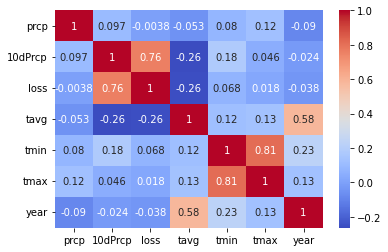

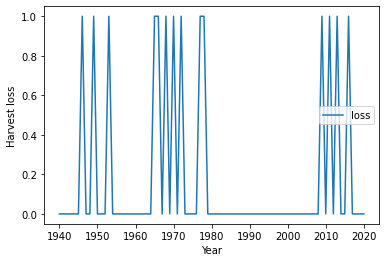

      Coeffcicients
year       0.002695
tavg      -0.118039
Prediction:  0.3284472710672248 %


In [108]:
# Import Meteostat library and dependencies
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily
from meteostat import Stations
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

prediction_year = 2130;
df = pd.DataFrame()

# Get nearby weather stations
stations = Stations()
#stations = stations.nearby(49.2497, -123.1193)
stations = stations.region('DE', 'BW')
station = stations.fetch(1)

# Create Point for Vancouver, BC
location = Point(48.775845, 9.182932, 70) # Stuttgart

# Create datset with data from meteostat
for x in range(1940, 2021):
    
    # Set time period
    start = datetime(x, 3, 1)
    end = datetime(x, 8, 31)

    # Get daily data
    data = Daily(location, start, end)
    data = data.fetch()

    # add for each row an entry with the sum of precipitation of last 8 days
    data['10dPrcp'] = data['prcp'].rolling(8).sum()
    # if there was a precipiation of over 95mm it will definitely be a harvest loss
    data['loss'] = np.where(data['10dPrcp']>95, 1, 0)
    # for some years or locations there is no avg. temp. -> temperature of 15 is used
    data[['tavg']] = data[['tavg']].fillna(value=15)
    
    # calculate tavg for entire year
    mean_tavg = data['tavg'].mean()
    del data['tavg']
    data['tavg'] = mean_tavg
    
    # calculate tmin for entire year
    mean_tmin = data['tmin']
    del data['tmin']
    data['tmin'] = mean_tmin
    
    # calculate tmax for entire year
    mean_tmax = data['tmax']
    del data['tmax']
    data['tmax'] = mean_tmax
    
    # wind speed is removed because there is often no data about it
    del data['wdir']
    
    # wind speed is removed because there is often no data about it
    del data['wspd']
    
    # wind peek gust is removed because there is often no data about it
    del data['wpgt']
    
    # air pressure is removed because there is often no data about it
    del data['pres']

    # # sun time is removed because there is often no data about it
    del data['tsun']
    
    # snow data is entirely removed because because there is often no data about it
    del data['snow']
    
    data.reset_index(inplace=True)
    
    # analysing missing values
    data.isnull().sum()

    # for each year only one entry is going to be used (the one with the highest cumulated precipitation in the last days)
    df = df.append(data.loc[data['10dPrcp'].argmax()])

# year is becoming an extra column to use it for linear regression
df['year'] = df['time'].dt.year
del df['time']
df['n'] = df['year']
df = df.set_index('n')

print("Created dataset")
print(df.head(200))

print("\nHeatmap showing the correlations to harvest loss")
df_heat = df.corr()
sns.heatmap(df_heat, annot=True, cmap='coolwarm')

# remove columns with low correlation to harvest loss
del df['prcp']
del df['tmax']

# displaying a plot
df.plot(y=['loss'])
plt.xlabel("Year")
plt.ylabel("Harvest loss")
plt.show()

# set X and y variables
X = df[['year', 'tavg']]
y = df['loss']

# doing linear regression
model = LinearRegression()
model.fit(X, y)
model.intercept_
model.coef_

model_results = pd.DataFrame(model.coef_, X.columns, columns=['Coeffcicients'])
print(model_results)

# making a prediction
new_situation = [
    prediction_year,
    18,
]
new_situation_predict = model.predict([new_situation])
print('Prediction: ', new_situation_predict[0], '%')



